# Summary Report
---

After analyzing the data of 4053 customers' behavior using Recency (how recently they purchased), Frequency (how often they purchase), and Monetary value (how much they spend). The customers were grouped into six main segments

## __Customer Segment Insights & Recommendations__

### 2D Compressed representation of Customer Segments and Their KPIs:
<center><img src='https://drive.google.com/uc?id=1Z1lDbhi8RnoMpP-A3KgjmVDQglfDNA4p' height='500' width='800'>    <img src='https://drive.google.com/uc?id=1dtXlPEFxHE6yYY1TO_n-zp9d6Elvwh1I' height='300' width='800'></center>

### __Cluster 0: `Churned Low-tier`__
#### __Insights__:
- These customers didn't buy in a while (~2 months) and usually only make very small purchases.
- They're low-value and their total overall sales is low.

#### __Recommendations__:
- Try simple reactivation offers like free delivery or a small discount.
- Use light remarketing ads or reminder emails.

### __Cluster 1: `At-Risk High spenders`__
#### __Insights__:
- This group used to spend a lot (avg ~240 per order) and bought more often than others, but they haven't purchased in almost 2 months.
- Losing them would hurt the most.

#### __Recommendations__:
- Send personalized offers with strong incentives.
- Highlight exclusive perks or loyalty rewards to remind them of their importance.
- Consider direct outreach if possible (Premium treatment).

### __Cluster 2: `Active Med-tier`__:
#### __Insights__:
- They purchased recently (within the last 2 weeks), spend a decent amount, and show signs of becoming regular customers.
- They're healthy, but there's room to grow.

#### __Recommendations__:
- Push upselling and cross-selling (premium versions, bundles).
- Promote loyalty programs or subscriptions to lock them in.
- Run ticket size stretching discounts to uplift monetary.

### __Cluster 3: `At-Risk Med-tier`__:
#### __Insights__:
- Average spenders, not too recent (last order ~50 days ago), and not very frequent.
- They could either stay or drift away.

#### __Recommendations__:
- Keep them engaged with seasonal promos and regular newsletters.
- Offer repeat purchase incentives like monthly/quarterly purchase target with cashback.
- Monitor carefully, as they could slide into churn.

### __Cluster 4: `New customers`__:
#### __Insights__:
- Very recent customers, but their first purchase was small and infrequent.
- They have the potential to become loyal and important customers.

#### __Recommendations__:
- Run a strong onboarding campaign (welcome discount, how-to emails).
- Nudge them to make a second order quickly with an acquisition journey.

### __Cluster 5: `Churned Med-tier`__:
#### __Insights__:
- Haven't purchased in a long time (~77 days) but did spend a moderate amount before.
- Their total overall sales is too big to lose.

#### __Recommendations__:
- Try last-chance reactivation campaigns with big discounts.
- Try Personalized emails with your current top products that everyone else is buying.

# Technical Implementation
----

## Installing Dependancies

In [ ]:
# Import Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from tqdm.auto import tqdm
tqdm.pandas()
from google.colab import auth
from google.cloud import bigquery
from sklearn.preprocessing import RobustScaler, QuantileTransformer
from scipy.stats import skew
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import plotly.express as px

## BigQuery Connection & Data Retrieval

In [ ]:
# Created Auth for google API
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
# Define data start, end and today's date
start_date = pd.to_datetime("2020-11-02")
end_date = pd.to_datetime("2021-01-30")
today = pd.to_datetime("2021-01-31", utc=True)

In [ ]:
# Define project ID
project_id = 'mh-tech-interviews'
client = bigquery.Client(project=project_id)

# Query to retrieve the data
query = f"""
-- Query the data of users that made purchases within certain time window
SELECT  user_pseudo_id,
        event_date,
        event_timestamp,

        -- Unnest event params to get the currency
        (SELECT value.string_value
         FROM UNNEST(event_params)
          WHERE key = 'currency') AS currency,

        -- Unnest event params to get the transaction id
        (SELECT value.string_value
         FROM UNNEST(event_params)
          WHERE key = 'transaction_id') AS transaction_id,

        -- Unnest event params to get the transaction value and if missing
        -- fill with manually Computed value from items
        COALESCE(
            (SELECT COALESCE(value.int_value, value.double_value)
             FROM UNNEST(event_params)
             WHERE key = 'value'),
            (SELECT SUM(CAST(i.price_in_usd AS FLOAT64) * i.quantity)
             FROM UNNEST(items) AS i)
        ) AS transaction_value
FROM    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
WHERE   _TABLE_SUFFIX BETWEEN '{str(start_date.date()).replace('-','')}'
                          AND '{str(end_date.date()).replace('-','')}'
    AND event_name = 'purchase'
"""

# Create the API object
job = client.query(query)

# Save the results into a dataframe
raw_data = job.to_dataframe()

## Exploratory Data Analysis and Cleaning

### Dataset Shape

In [ ]:
# Data shape
print(raw_data.shape)

(5659, 6)


### Null Values and Datatypes

In [ ]:
# Null values and data types
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5659 entries, 0 to 5658
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_pseudo_id     5659 non-null   object 
 1   event_date         5659 non-null   object 
 2   event_timestamp    5659 non-null   Int64  
 3   currency           5659 non-null   object 
 4   transaction_id     4786 non-null   object 
 5   transaction_value  5228 non-null   float64
dtypes: Int64(1), float64(1), object(4)
memory usage: 270.9+ KB


#### Datatypes

`timestamp` and `date` columns needs to have the correct datatypes

In [ ]:
raw_data['event_date'] = pd.to_datetime(raw_data['event_date'],
                                        utc=True)
raw_data['event_timestamp'] = pd.to_datetime(raw_data['event_timestamp'],
                                             unit='us',
                                             utc=True)

#### Null Values

##### Transaction_id
Some `transaction` ids are null which means the site or app didn't send it at the time of purchase. The revenue amount is still tracked, but we can't always tell whether two events belong to the same order. This creates a challenge when counting number of purchases versus total revenue. We can solve that by generating a unique ID using the rest of the attributes (user_id, timestamp, etc..)

In [ ]:
# fill missing transaction ids using user id and timestamp combination
raw_data.loc[
    raw_data['transaction_id'].isna(), 'transaction_id'
    ] = raw_data['user_pseudo_id'].astype('str') \
    + "_" + raw_data['event_timestamp'].astype('str')

##### Transaction_value
Even after filling missing values with manually calculated transaction values from the items array, Some values are still missing so lets further investigate the null records and make sure they're actually empty

In [ ]:
# Query to investigate missing transaction values
query = f"""
SELECT event_date, event_timestamp, items
FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
WHERE event_name = 'purchase'
  AND _TABLE_SUFFIX BETWEEN '{start_date}' AND '{end_date}'
  AND (SELECT COALESCE(value.int_value, value.double_value)
       FROM UNNEST(event_params) WHERE key = 'value') IS NULL
LIMIT 20;
"""

# Create the API object
job = client.query(query)

# Save the results into a dataframe
empty_values = job.to_dataframe()

# print the items value
empty_values['items'].values[0]

array([{'item_id': '(not set)', 'item_name': '(not set)', 'item_brand': '(not set)', 'item_variant': '(not set)', 'item_category': '(not set)', 'item_category2': '(not set)', 'item_category3': '(not set)', 'item_category4': '(not set)', 'item_category5': '(not set)', 'price_in_usd': None, 'price': None, 'quantity': None, 'item_revenue_in_usd': None, 'item_revenue': None, 'item_refund_in_usd': None, 'item_refund': None, 'coupon': '(not set)', 'affiliation': '(not set)', 'location_id': '(not set)', 'item_list_id': '(not set)', 'item_list_name': '(not set)', 'item_list_index': '(not set)', 'promotion_id': '(not set)', 'promotion_name': '(not set)', 'creative_name': '(not set)', 'creative_slot': '(not set)'}],
      dtype=object)

These records looks faulty from the datasource itself. Hence, the action here is to drop these rows.

In [ ]:
# Drop records with null transaction values
raw_data = raw_data.dropna(subset=['transaction_value']).reset_index(drop=True)

### Summary Statistics

In [ ]:
# Summary Stats
raw_data.describe(include='all')

,user_pseudo_id,event_date,event_timestamp,currency,transaction_id,transaction_value
count,5228,5228,5228,5228,5228,5228.000000
unique,4053,NaN,NaN,1,4908,NaN
top,63264809.7446857295,NaN,NaN,USD,2484119233,NaN
freq,16,NaN,NaN,5228,4,NaN
mean,NaN,2020-12-09 10:23:52.287681792+00:00,2020-12-09 22:27:32.729505+00:00,NaN,NaN,69.133573
min,NaN,2020-11-02 00:00:00+00:00,2020-11-02 03:12:12.569546+00:00,NaN,NaN,1.400000
25%,NaN,2020-11-23 00:00:00+00:00,2020-11-23 20:37:35.548610+00:00,NaN,NaN,27.180000
50%,NaN,2020-12-08 00:00:00+00:00,2020-12-08 10:05:14.780824+00:00,NaN,NaN,48.000000
75%,NaN,2020-12-19 00:00:00+00:00,2020-12-19 05:58:10.408594+00:00,NaN,NaN,84.100000
max,NaN,2021-01-30 00:00:00+00:00,2021-01-30 21:38:13.988852+00:00,NaN,NaN,1530.400000


From the number of unique transaction ids and the number of non null transaction ids we notice that there are some duplicated transaction ids that require further investigation

### Duplicates

In [ ]:
# checking if entire rows are null
raw_data[raw_data.duplicated()]

,user_pseudo_id,event_date,event_timestamp,currency,transaction_id,transaction_value


In [ ]:
# Checking the duplicated rows
duplicated_examples = raw_data[
    raw_data['transaction_id'].duplicated() &
    (~raw_data['transaction_id'].isna())
    ]['transaction_id'].sample(10)

# Display the duplicates in sorted order
raw_data[
    raw_data['transaction_id'].isin(duplicated_examples)
    ].sort_values('transaction_id')

,user_pseudo_id,event_date,event_timestamp,currency,transaction_id,transaction_value
1500,7158462.4817271255,2020-11-20 00:00:00+00:00,2020-11-20 03:28:15.780277+00:00,USD,1591457215,18.60
1501,7158462.4817271255,2020-11-20 00:00:00+00:00,2020-11-20 03:28:15.825949+00:00,USD,1591457215,18.60
1488,72137012.1051607566,2020-11-20 00:00:00+00:00,2020-11-20 12:10:26.722494+00:00,USD,1888758083,43.00
1489,72137012.1051607566,2020-11-20 00:00:00+00:00,2020-11-20 12:10:26.744913+00:00,USD,1888758083,43.00
2078,4042858.3888779946,2020-11-24 00:00:00+00:00,2020-11-24 07:03:40.951766+00:00,USD,2085411422,71.20
2077,4042858.3888779946,2020-11-24 00:00:00+00:00,2020-11-24 07:03:41.008761+00:00,USD,2085411422,71.20
1482,4707239.1008432127,2020-11-20 00:00:00+00:00,2020-11-20 08:49:28.441889+00:00,USD,285128230,60.24
1483,4707239.1008432127,2020-11-20 00:00:00+00:00,2020-11-20 08:49:28.416610+00:00,USD,285128230,60.24
1893,76356424.0978454972,2020-11-18 00:00:00+00:00,2020-11-18 22:16:25.541746+00:00,USD,3176126266,85.44
1892,76356424.0978454972,2020-11-18 00:00:00+00:00,2020-11-18 22:16:25.571567+00:00,USD,3176126266,85.44


Seems like the problem is happening due to the purchase event being re-sent as the duplication happens within few micro seconds

In [ ]:
# removing the microseconds element from the timestamp
raw_data['event_timestamp'] = pd.to_datetime(
    raw_data['event_timestamp'].dt.strftime("%Y-%m-%d %H:%M:%S")
    )

# Remove entire duplicated rows
raw_data = raw_data.drop_duplicates().reset_index(drop=True)

# double checking that no more duplicated values exist
raw_data[raw_data['transaction_id'].isin(
    raw_data[raw_data['transaction_id'].duplicated() &
              (~raw_data['transaction_id'].isna())]['transaction_id'].unique())]

,user_pseudo_id,event_date,event_timestamp,currency,transaction_id,transaction_value
241,86939274.9526508063,2021-01-11 00:00:00+00:00,2021-01-11 05:41:47,USD,7135087482,70.40
242,86939274.9526508063,2021-01-11 00:00:00+00:00,2021-01-11 05:42:50,USD,7135087482,70.40
362,87047667.1042912591,2021-01-01 00:00:00+00:00,2021-01-01 04:55:33,USD,6542146188,13.60
364,87047667.1042912591,2021-01-01 00:00:00+00:00,2021-01-01 04:54:35,USD,6542146188,13.60
418,28988900.6959315645,2021-01-05 00:00:00+00:00,2021-01-05 13:32:59,USD,2847456544,24.00
...,...,...,...,...,...,...
4784,7634543.7021985089,2020-12-09 00:00:00+00:00,2020-12-09 02:55:32,USD,4866129469,113.44
4785,7634543.7021985089,2020-12-09 00:00:00+00:00,2020-12-09 02:55:04,USD,4866129469,113.44
4786,7634543.7021985089,2020-12-09 00:00:00+00:00,2020-12-09 02:55:45,USD,4866129469,113.44
4892,8083450.3844124226,2020-12-15 00:00:00+00:00,2020-12-15 16:32:32,USD,5519043463,128.48


Some values still exist but the difference between the is just 1 second which means the few micro seconds where just enough to push the timestamp to the next second. This can be solved by keeping latest record

In [ ]:
# Keep the most recent record per user id and transcation id
raw_data = raw_data.sort_values(
    ['event_date', 'user_pseudo_id', 'transaction_value']
    ).drop_duplicates(
        subset=['event_date', 'user_pseudo_id', 'transaction_id', 'transaction_value'],
        keep='last'
        ).reset_index(drop=True)

# double checking that no more duplicated values exist
raw_data[raw_data['transaction_id'].isin(
    raw_data[raw_data['transaction_id'].duplicated()]['transaction_id'].unique()
    )]

,user_pseudo_id,event_date,event_timestamp,currency,transaction_id,transaction_value


## RFM

In [ ]:
# Aggregate RFM
rfm = raw_data.groupby('user_pseudo_id').agg({
    'event_date': lambda x: (today - x.max()).days,
    'transaction_id': 'nunique',
    'transaction_value': 'sum'
}).reset_index()

# rename columns
rfm.columns = ['user_pseudo_id', 'recency', 'frequency', 'monetary']

In [ ]:
# stats
rfm.describe()

,recency,frequency,monetary
count,4053.000000,4053.000000,4053.000000
mean,50.609672,1.210955,83.864582
std,22.492120,0.806047,104.250402
min,1.000000,1.000000,1.400000
25%,39.000000,1.000000,30.000000
50%,53.000000,1.000000,55.000000
75%,67.000000,1.000000,97.360000
max,90.000000,16.000000,1530.400000


## Visualizations

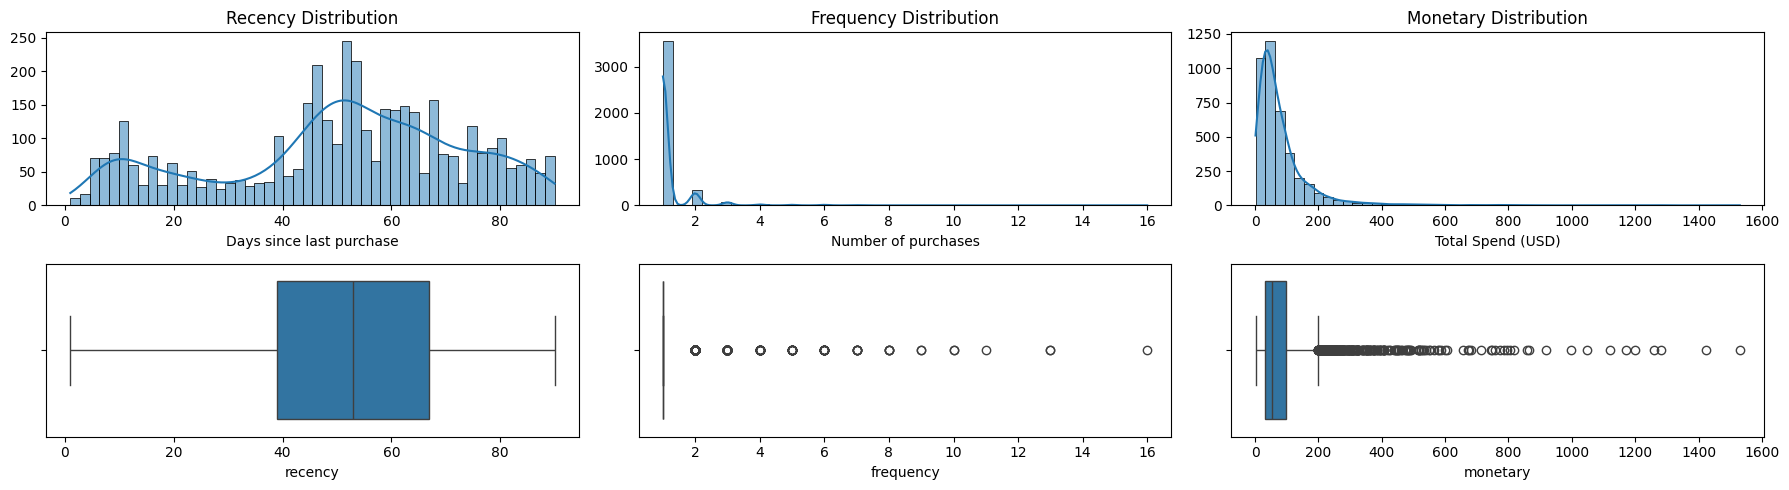

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 5))

# Recency Distribution
sns.histplot(rfm['recency'], bins=50, kde=True, ax=axes[0][0])
sns.boxplot(x=rfm['recency'], ax=axes[1][0])
axes[0][0].set_title('Recency Distribution')
axes[0][0].set_xlabel('Days since last purchase')
axes[0][0].set_ylabel('')

# Frequency Distribution
sns.histplot(rfm['frequency'], bins=50, kde=True, ax=axes[0][1])
sns.boxplot(x=rfm['frequency'], ax=axes[1][1])
axes[0][1].set_title('Frequency Distribution')
axes[0][1].set_xlabel('Number of purchases')
axes[0][1].set_ylabel('')

# Monetary Distribution
sns.histplot(rfm['monetary'], bins=50, kde=True, ax=axes[0][2])
sns.boxplot(x=rfm['monetary'], ax=axes[1][2])
axes[0][2].set_title('Monetary Distribution')
axes[0][2].set_xlabel('Total Spend (USD)')
axes[0][2].set_ylabel('')

plt.tight_layout()
plt.show()

The data are heavily skewed and heavy outliers are present which could cause problems (bias towards higher values) while clustering. Hence, we will need to log-transform the data then scale it to make the distribution closer to gaussian.

## Preprocessing

### Sknewness

In [ ]:
# Skewness test
features = ["recency", "frequency", "monetary"]
for col in features:
    skewness = skew(rfm[col].dropna())
    print(f"{col}: skewness = {skewness:.2f}")

recency: skewness = -0.42
frequency: skewness = 7.43
monetary: skewness = 5.26


Based on the skew test above:
- `frequency`: count data that follows poisson distribution so we will use `Quantile Transformation`.
- `monetary`: Continuous data so we will use `log transformation`.
- `recency`: looks fine without any transformation.

After trying to transform the `frequency` using `Quantile transformation` and optimizing the clusters it yielded the following results:


<center><img src='https://drive.google.com/uc?id=1JK7ZPgKF8YCzseD6XEaYoRflluAoLSbG' height='300' width='400'>    <img src='https://drive.google.com/uc?id=1G0wmhnFQ24m1CHxr_2IGaTzcApw74qHl' height='300' width='400'></center>

Which shows that the clustering was heavily dominated by `frequency` so We're going to encode the frequency into 3 categories instead `rare` (1 transaction): 1, `occasional` (2 transactions): 2, `loyal` (3+ transactions): 3

Then apply the `Quantile Transformation` to reduce the skewness before clustering.

In [ ]:
# Map frequency to categories
conditions = [
    (rfm['frequency'] == 1),
    (rfm['frequency'] == 2),
    (rfm['frequency'] > 2)
]

choices = [1, 2, 3]

rfm['frequency_cat'] = np.select(conditions, choices)

# Quantile transform frequency
qt = QuantileTransformer(output_distribution="normal", random_state=42)
rfm["frequency_qt"] = qt.fit_transform(rfm[["frequency_cat"]])
rfm['frequency_log'] = np.log1p(rfm['frequency_cat'])

In [ ]:
# Log transform monetary
rfm['monetary_log'] = np.log1p(rfm['monetary'])

### Scaling

In [ ]:
# Scaling the data
scaler = RobustScaler()
rfm_scaled = scaler.fit_transform(
    rfm[['recency', 'frequency_log', 'monetary_log']]
    )

In [ ]:
# Group back into one dataframe
rfm_preprocessed = pd.DataFrame(rfm_scaled,
                                columns=["recency", "frequency", "monetary"],
                                index=rfm["user_pseudo_id"])

## Clustering

#### Elbow method

  0%|          | 0/9 [00:00<?, ?it/s]

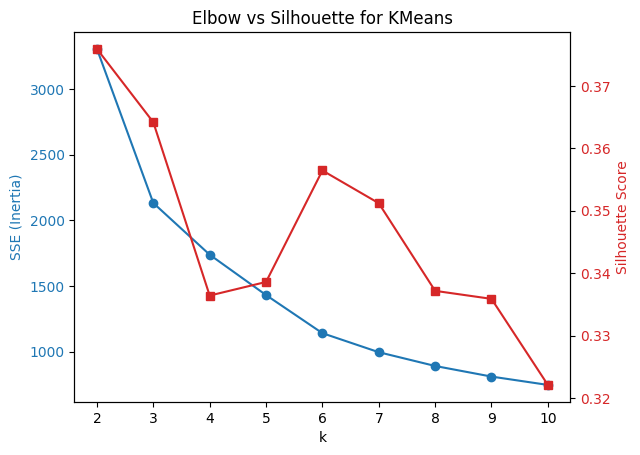

In [ ]:
# create dictionaries for results logging
sse = {}
sil = {}

# Try different K values and log the results
for k in tqdm(range(2, 11)):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_preprocessed)
    sse[k] = kmeans.inertia_
    sil[k] = silhouette_score(rfm_preprocessed, labels)

# Plot elbow graph of silhouette and intertia
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('k')
ax1.set_ylabel('SSE (Inertia)', color=color)
ax1.plot(list(sse.keys()), list(sse.values()), marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(list(sil.keys()), list(sil.values()), marker='s', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Elbow vs Silhouette for KMeans')
plt.show()

Based on the graph the best number of clusters is `6` which has a significant inertia drop while still having clean cluster cuts based on the silhouette score

#### Create best cluster

In [ ]:
# Final clustering
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
rfm["cluster"] = kmeans.fit_predict(rfm_preprocessed)

# Cluster Profiling
cluster_profile = rfm.groupby("cluster").agg(
    recency=("recency", "mean"),
    frequency=("frequency", "mean"),
    monetary=("monetary", "mean"),
    total_orders=("frequency", "sum"),
    total_sales=("monetary", "sum"),
    count=("user_pseudo_id", "count")
).reset_index()

display(cluster_profile.set_index('cluster'))

,recency,frequency,monetary,total_orders,total_sales,count
cluster,,,,,,
0,61.472023,1.014347,19.193357,707,13377.77,697
1,57.467742,1.793548,240.764516,1112,149274.00,620
2,15.277559,1.279528,104.763858,650,53220.04,508
3,50.257674,1.123721,60.523256,1208,65062.50,1075
4,18.473039,1.036765,23.762843,423,9695.24,408
5,76.939597,1.084564,66.139060,808,49273.60,745


### Interpretation

In [ ]:
# Class 0 -> No recent purchases, low frequency, and low spendings.
cluster_profile.loc[
    cluster_profile['cluster'] == 0,
    'Class'] = 'Churned Low-tier'

# Class 1 -> No recent purchases, highest frequency, and highest spendings.
cluster_profile.loc[
    cluster_profile['cluster'] == 1,
    'Class'] = 'At-Risk High spenders'

# Class 2 -> Recent purchases, high frequency, and high spendings.
cluster_profile.loc[
    cluster_profile['cluster'] == 2,
    'Class'] = 'Active Med-tier'

# Class 3 -> No recent purchases, Med frequency, and med spendings.
cluster_profile.loc[
    cluster_profile['cluster'] == 3,
    'Class'] = 'At-Risk Med-tier'

# Class 4 -> Recent purchases, low frequency, and low spendings.
cluster_profile.loc[
    cluster_profile['cluster'] == 4,
    'Class'] = 'New customers'

# Class 5 -> No recent purchases, low infrequency, and spend little.
cluster_profile.loc[
    cluster_profile['cluster'] == 5,
    'Class'] = 'Churned Med-tier'

cluster_profile

,cluster,recency,frequency,monetary,total_orders,total_sales,count,Class
0,0,61.472023,1.014347,19.193357,707,13377.77,697,Churned Low-tier
1,1,57.467742,1.793548,240.764516,1112,149274.00,620,At-Risk High spenders
2,2,15.277559,1.279528,104.763858,650,53220.04,508,Active Med-tier
3,3,50.257674,1.123721,60.523256,1208,65062.50,1075,At-Risk Med-tier
4,4,18.473039,1.036765,23.762843,423,9695.24,408,New customers
5,5,76.939597,1.084564,66.139060,808,49273.60,745,Churned Med-tier


### Cluster visualization

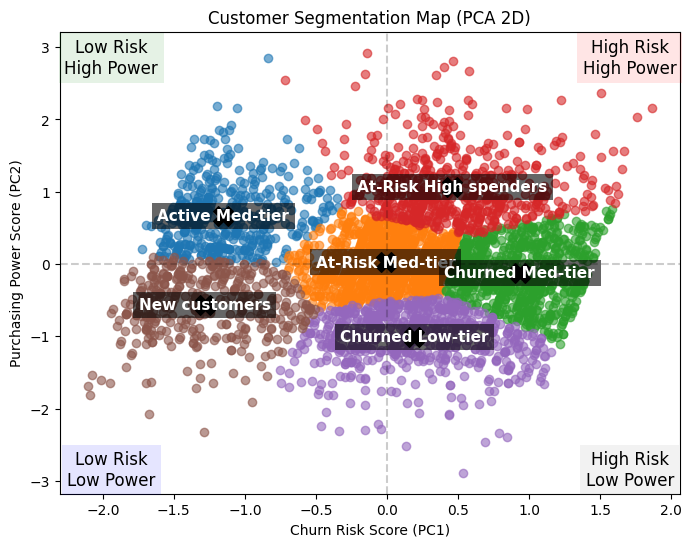

In [ ]:
# Reduce to 2D using PCA
pca = PCA(n_components=2, random_state=42)
rfm_2d = pca.fit_transform(rfm_preprocessed)

# Add cluster labels
rfm["cluster_2d_x"] = rfm_2d[:,0]
rfm["cluster_2d_y"] = rfm_2d[:,1]

plt.figure(figsize=(8,6))

# Scatter plot by cluster
for cluster in rfm["cluster"].unique():
    subset = rfm[rfm["cluster"] == cluster]
    class_label = cluster_profile[
        cluster_profile['cluster'] == cluster
    ]['Class'].values[0]
    plt.scatter(
        subset["cluster_2d_x"], subset["cluster_2d_y"],
        label=f"{class_label}", alpha=0.6
    )

# Compute centroids
centroids = rfm.groupby("cluster")[["cluster_2d_x","cluster_2d_y"]].mean()

# Plot centroids + annotate them with class labels
for cluster, row in centroids.iterrows():
    class_label = cluster_profile[
        cluster_profile['cluster'] == cluster
    ]['Class'].values[0]
    plt.scatter(row["cluster_2d_x"], row["cluster_2d_y"],
                marker="X", s=200, c="black")  # centroid marker
    plt.text(row["cluster_2d_x"], row["cluster_2d_y"],
             f"{class_label}", fontsize=11, fontweight="bold",
             ha="center", va="center", color="white",
             bbox=dict(facecolor="black", alpha=0.6, edgecolor="none"))

# Axis lines for quadrants
plt.axhline(0, color='black', linestyle='--', alpha=0.2)
plt.axvline(0, color='black', linestyle='--', alpha=0.2)

# Labels for quadrants
plt.text(
    1.71, 2.85, "High Risk\nHigh Power", fontsize=12, ha='center',
    va='center', bbox=dict(facecolor='red', alpha=0.1, edgecolor='none')
    )
plt.text(
    -1.94, 2.85, "Low Risk\nHigh Power", fontsize=12, ha='center',
    va='center', bbox=dict(facecolor='green', alpha=0.1, edgecolor='none')
    )
plt.text(
    -1.94, -2.85, "Low Risk\nLow Power", fontsize=12, ha='center',
    va='center', bbox=dict(facecolor='blue', alpha=0.1, edgecolor='none')
    )
plt.text(
    1.71, -2.85, "High Risk\nLow Power", fontsize=12, ha='center',
    va='center', bbox=dict(facecolor='gray', alpha=0.1, edgecolor='none')
    )

# Titles + legend
plt.title("Customer Segmentation Map (PCA 2D)")
plt.xlabel("Churn Risk Score (PC1)")
plt.ylabel("Purchasing Power Score (PC2)")
# plt.legend()
plt.show()

#### Interactive Cluster Visualization

In [ ]:
# Merge cluster names
rfm_plot = rfm.merge(
    cluster_profile[["cluster", "Class"]],
    on="cluster",
    how="left"
    )

# Interactive PCA scatter plot
fig = px.scatter(
    rfm_plot,
    x="cluster_2d_x",
    y="cluster_2d_y",
    color="Class",
    hover_data=["cluster", "Class", "recency", "frequency", "monetary"],
    opacity=0.7,
    title="Customer Segmentation (2D PCA Projection - Interactive)",
    labels={
        "cluster_2d_x": "Churn Risk Score (PC1)",
        "cluster_2d_y": "Purchasing Power Score (PC2)"
    }
)

# Add centroids (using PCA coords)
centroids_pca = rfm_plot.groupby("cluster")[
    ["cluster_2d_x","cluster_2d_y"]
    ].mean().reset_index()
centroids_pca = centroids_pca.merge(
    cluster_profile[["cluster", "Class"]],
    on="cluster",
    how="left"
    )

fig.add_scatter(
    x=centroids_pca["cluster_2d_x"],
    y=centroids_pca["cluster_2d_y"],
    mode="markers+text",
    marker=dict(size=12, color="black", symbol="x"),
    text=centroids_pca["Class"],
    textposition="top center",
    name="Centroids"
)

fig.show()

In [ ]:
cluster_profile.set_index('Class')

,cluster,recency,frequency,monetary,total_orders,total_sales,count
Class,,,,,,,
Churned Low-tier,0,61.472023,1.014347,19.193357,707,13377.77,697
At-Risk High spenders,1,57.467742,1.793548,240.764516,1112,149274.00,620
Active Med-tier,2,15.277559,1.279528,104.763858,650,53220.04,508
At-Risk Med-tier,3,50.257674,1.123721,60.523256,1208,65062.50,1075
New customers,4,18.473039,1.036765,23.762843,423,9695.24,408
Churned Med-tier,5,76.939597,1.084564,66.139060,808,49273.60,745


# Production Architecture

<center><img src='https://drive.google.com/uc?id=10-XI1RH3X_8l-UGjCCM6a_rq_AQ-JNqn' height='500' width='800'></center>